In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import cm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from src.kohonen import Kohonen

In [2]:
df = pd.read_csv("./datasets/clean_acath.csv")
df.rename(columns={"cad.dur": "duracion"}, inplace=True)
df.head()

,sex,age,duracion,choleste,sigdz,tvdlm
0,0,73,132,268.0,1,1.0
1,0,68,85,120.0,1,1.0
2,0,54,45,228.0,1,0.0
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0


In [3]:
with_disease    = df[df['sigdz'] == 1]
without_disease = df[df['sigdz'] == 0]
print(f" amount with disease: {len(with_disease)}")
print(f" amount without disease: {len(without_disease)}")

 amount with disease: 2332
 amount without disease: 1169


In [4]:
# Balance amount of positive and negative
with_disease_sample = with_disease.sample(n=len(without_disease), random_state=69)
df = pd.concat([without_disease, with_disease_sample])

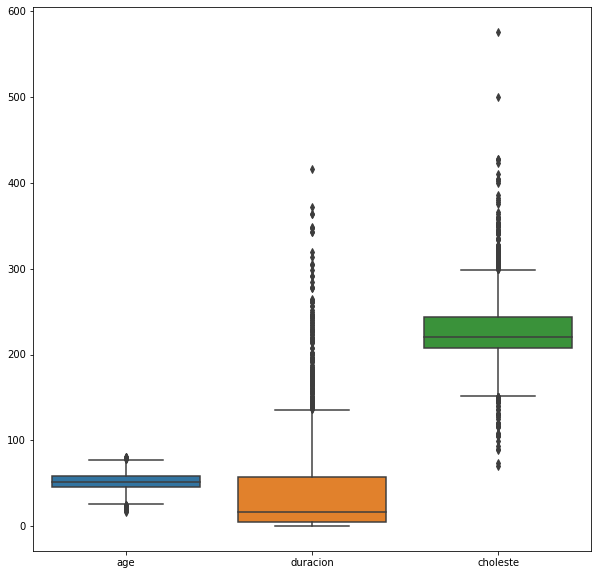

In [5]:
numeric_cols = ["age", "duracion", "choleste"]
_, ax = plt.subplots(figsize=(10,10))
sns.boxplot(ax=ax, data=df[numeric_cols])
plt.show()

In [6]:
numeric_cols = ["age", "duracion", "choleste"]
df_norm = df[numeric_cols].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
df_norm.insert(len(numeric_cols), 'sigdz', df['sigdz'])
df_norm

,age,duracion,choleste,sigdz
3,0.646010,0.757554,0.460347,0
4,0.447290,-0.604095,1.048792,0
11,-1.639269,0.033639,0.754570,0
12,1.738969,-0.552387,0.190643,0
20,0.049850,-0.207666,0.337754,0
...,...,...,...,...
1042,-1.043110,0.516249,-0.275210,1
211,0.347930,-0.448971,3.427092,1
1171,-0.049510,-0.431735,-0.544914,1
679,1.639609,2.084731,2.863165,1


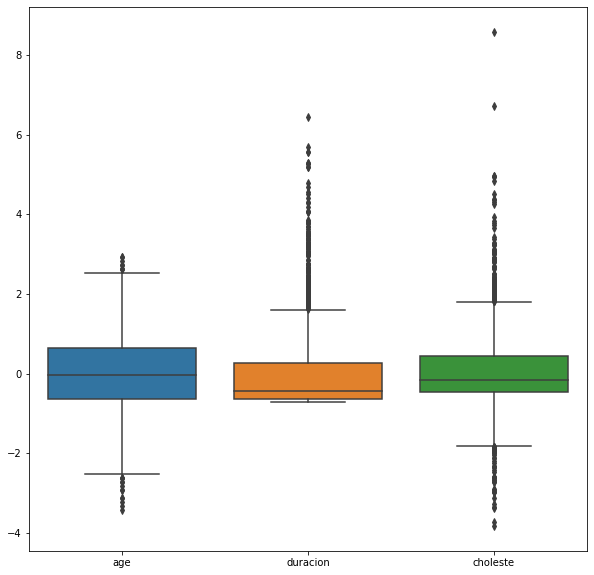

In [7]:
_, ax = plt.subplots(figsize=(10,10))
sns.boxplot(ax=ax, data=df_norm[numeric_cols])
plt.show()

In [8]:
train, test = train_test_split(df_norm, test_size=0.2, random_state=69)
print(f"training amount: {len(train)}\ntesting amount: {len(test)}")
train.head()

training amount: 1870
testing amount: 468


,age,duracion,choleste,sigdz
1934,0.646010,-0.673040,-1.599212,1
327,0.546650,1.395288,0.386791,0
395,1.738969,-0.552387,0.435828,1
343,1.341530,-0.500679,-0.152617,1
3474,0.248570,-0.414499,-1.010766,0


In [148]:
X = df_norm.iloc[:, :-1].to_numpy()
model = Kohonen(
    input_size=3,
    k=10,
    epochs=40
)
model.fit(X)

Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25
Epoch: 30
Epoch: 35
Epoch: 40


In [140]:
def create_count_matrix(data, model, data_columns, result_column):
        k = len(model.output_neurons)
        count_matrix = [[[0, 0] for _ in range(k)] for _ in range(k)]
        for _, row in data.iterrows():
            xp = row[data_columns].to_numpy()
            coords = model.predict(xp)
            count_matrix[coords[0]][coords[1]][int(row[result_column])] += 1
            
        return count_matrix

In [141]:
count_matrix = create_count_matrix(df_norm, model, numeric_cols, 'sigdz')
print(np.array(count_matrix).sum())

2338


In [142]:
def classify_kohonen(data, model, data_columns, result_column):
    matrix = model.output_neurons
    k = len(matrix)
    class_matrix = [[None for x in range(k)] for y in range(k)]
    count_matrix = create_count_matrix(data, model, data_columns, result_column)
    for i in range(k):
        for j in range(k):
            if count_matrix[i][j][0] == 0 and count_matrix[i][j][1] == 0:
                class_matrix[i][j] = None
            elif count_matrix[i][j][0] >= count_matrix[i][j][1]:
                class_matrix[i][j] = 0
            else: 
                 class_matrix[i][j] = 1
    
    return class_matrix

In [143]:
grid = classify_kohonen(df_norm, model, numeric_cols, 'sigdz')

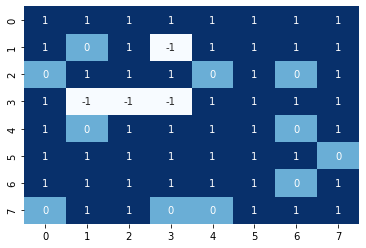

In [144]:
sigdz_matrix = pd.DataFrame(grid).fillna(-1)
sns.heatmap(sigdz_matrix, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.show()

In [145]:
pred = []
for index, row in test.iterrows():
    y = row[numeric_cols].to_numpy()
    row, col = model.predict(y)
    pred.append(grid[row][col])

In [146]:
data = {
    'y_actual': list(test["sigdz"]),
    'y_predicted': list(pred)
}
conf = pd.DataFrame(data, columns=['y_actual','y_predicted'])
conf.head()

,y_actual,y_predicted
0,0,1
1,0,1
2,1,1
3,1,1
4,1,1


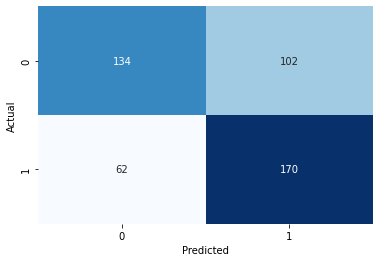

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       236
           1       0.62      0.73      0.67       232

    accuracy                           0.65       468
   macro avg       0.65      0.65      0.65       468
weighted avg       0.65      0.65      0.65       468



In [147]:
confusion_matrix = pd.crosstab(conf['y_actual'], conf['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.show()
print(classification_report(conf['y_actual'], conf['y_predicted']))